<a href="https://colab.research.google.com/github/joeybose/GGM_LOG_Tutorial/blob/master/LoG_GGM_geometry_examples.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## This part of the coding notebook is companion to Part 2 - Differential Geometry Primer

# Spherical Geometry

In [1]:
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import os
import torch
from torch import Tensor
import torch.nn.functional as F
import seaborn as sns
from scipy.stats import kde
import sys
import math
from typing import Any, Tuple, Optional

print(torch.__version__)
print(torch.cuda.is_available())

2.5.1+cu121
False


In [2]:
!pip install git+https://github.com/geoopt/geoopt.git

  Cloning https://github.com/geoopt/geoopt.git to /tmp/pip-req-build-qwwh57gs
  Running command git clone --filter=blob:none --quiet https://github.com/geoopt/geoopt.git /tmp/pip-req-build-qwwh57gs
  Resolved https://github.com/geoopt/geoopt.git to commit eaadc68fcae361778edf078b503ed79e4497c071
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for geoopt: filename=geoopt-0.5.1-py3-none-any.whl size=90025 sha256=ec52267efcc8c6a28982b4e39f1a45b8eaa20d6a2d3b67a06a885e09f9dc39a9
  Stored in directory: /tmp/pip-ephem-wheel-cache-sq9ubho_/wheels/09/2e/93/3d8584e16e5ec698ebc7f6b77c083cabd05967833af32f69af
Successfully built geoopt


Spheres are defined as submanifolds in an Euclidean space of points with a unit Euclidean norm.
Precisely, an $d$-sphere is $\mathbb{S}^d = \{x\in \mathbb{R}^{d+1}: \|x\|_2 =1 \}$.
Therefore the ambient space dimensionality of a $d$ sphere is $m=d+1$.
Tori are products of $1$-spheres (or circles); that is $\mathbb{T}^d = \Pi_{i=1}^d \mathbb{S}^1 $.
Naturally, we can embed a $d$-torus in a $m=2d$-dimensional ambient space.

Spheres are also constant curvature manifolds which means an equivalent way of specifying the manifold is using the ambient space coordinate system as well as the curvature constant $K>0$, $  $. This viewpoint will aid us when we consider constant negative-curvature manifolds (Hyperbolic spaces with $K<0$).

In [3]:
EPS = 1e-9
MIN_NORM = 1e-15

def sphere_inner_product(x: Tensor, y: Tensor, keepdim: bool = False, dim: int = -1) -> Tensor:
    # Check if x and y are on the sphere
    x_norm = torch.norm(x, p=2, dim=dim, keepdim=True)
    y_norm = torch.norm(y, p=2, dim=dim, keepdim=True)

    if not torch.allclose(x_norm, torch.ones_like(x_norm)):
        x = x / (x_norm + EPS)
    if not torch.allclose(y_norm, torch.ones_like(y_norm)):
        y = y / (y_norm + EPS)

    # Inner product is simply the Euclidean inner product
    ret = torch.sum(x * y, dim=dim, keepdim=keepdim)
    return ret

def sphere_norm(x: Tensor, **kwargs: Any) -> Tensor:
    product = sphere_inner_product(x, x, **kwargs)
    ret = torch.sqrt(product)
    return ret

@staticmethod
def proj2manifold(x: Tensor) -> Tensor:
    return x / (x.norm(dim=1).unsqueeze(-1) + EPS)

## Choices of paramterization of the sphere

### Polar Coordinates
When $d=2$ we can use polar coordinates to parametrize $\mathbb{S}^2_1$. In polar coordinates, we can represent any point $x \in \mathbb{S}^2$ using two angles $\theta, \psi$ which are the polar and azimuth angles. The range of the polar angle is $\theta \in [ 0, \pi)$ and the range for the azimuth angle is $\psi \in [0, 2\pi)$. In ambient Cartesian coordinates $r(\theta, \psi) = (\sin (\theta) \cos (\psi), \sin (\theta) \sin(\psi), \cos (\theta))$. Finally, the volume form is given by $\sqrt{\text{det}|G(\theta, \psi)|} = \sin (\theta)$.


Let's now visualize the $\mathbb{S}^2_1$ sphere embedded in $\mathbb{R}^3$

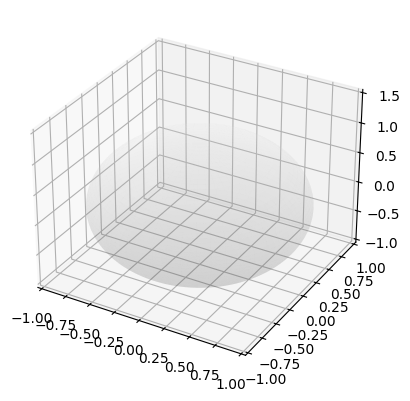

In [4]:
def visualize_hypersphere(points=None, traj=None):
  fig = plt.figure()
  ax = fig.add_subplot(projection='3d')

  # Make data
  u = torch.linspace(0, 2 * np.pi, 100)
  v = torch.linspace(0, np.pi, 100)
  x = 1 * torch.outer(torch.cos(u), torch.sin(v))
  y = 1 * torch.outer(torch.sin(u), torch.sin(v))
  z = 1 * torch.outer(torch.ones(u.size()), torch.cos(v))

  # Plot the surface
  ax.plot_surface(x, y, z, cmap="Greys_r", zorder=1, alpha=0.1)

  if points is not None:
    ax.scatter(points[:, 0], points[:, 1], points[:, 2], c='r', marker='o',
               s=20, zorder=2)
  if traj is not None:
    ax.scatter(traj[:, 0], traj[:, 1], traj[:, 2], color="blue", marker='o')

  # Set an equal aspect ratio
  ax.set_aspect('auto')
  # set z axis limit
  ax.set_zlim(-1, 1.5)
  # set x axis limit
  ax.set_xlim(-1, 1)
  # set y axis limit
  ax.set_ylim(-1, 1)

  plt.show()

visualize_hypersphere()


### Extrinsic Parametrization

An equally compatible paramterization is to define $\mathbb{S}^2_1$ as the set of points embedded in $\mathbb{R}^3$ with unit norm. This is visualized below.

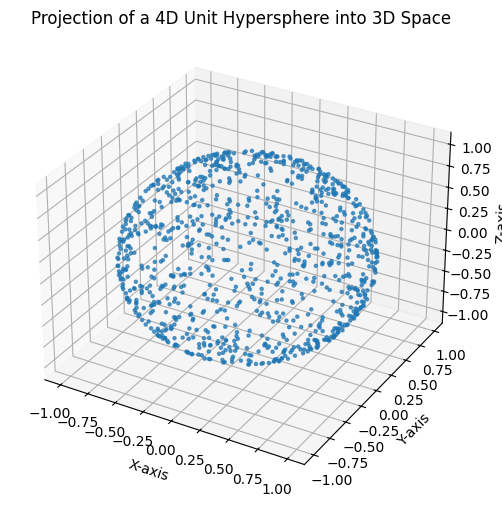

In [5]:
import pdb

def visualize_sphere_extrinsic(num_points: int = 1000):
  # Number of points to sample on the hypersphere
  num_points = 1000

  # Dimension of the hypersphere (4D in this case)
  n_dim = 3

  # Generate random points from a standard normal distribution
  x = torch.randn(num_points, n_dim)

  # Normalize each point to lie on the unit hypersphere
  x_projected = x / x.norm(dim=1, keepdim=True)

  # Convert tensors to numpy arrays for plotting
  x_np = x_projected.numpy()

  # Set up the 3D plot
  fig = plt.figure(figsize=(8, 6))
  ax = fig.add_subplot(111, projection='3d')

  # Plot the projected points
  ax.scatter(x_np[:, 0], x_np[:, 1], x_np[:, 2], s=5, alpha=0.7)

  # Label the axes
  ax.set_xlabel('X-axis')
  ax.set_ylabel('Y-axis')
  ax.set_zlabel('Z-axis')
  ax.set_title('Projection of a 4D Unit Hypersphere into 3D Space')

  # Show the plot
  plt.show()

visualize_sphere_extrinsic(num_points=10000)

## Common manifold operations for the sphere

### Exponential map

The exponential map in $\mathbb{S}^2_1$ is:

\begin{equation}
    \exp_{x}(v) = \cos \left(||v||_2\right)x + \sin \left(||v||_2 \right) \frac{v}{||v||_2}
\end{equation}

### Logarithmic map
The logarithmic map in $\mathbb{S}^2_1$:
\begin{equation}
    \log_{x}(y) = \frac{\cos^{-1}(\alpha)}{\sqrt{1 - \alpha^2}} (y - \alpha x),
\end{equation}
where $\alpha = \langle x, y \rangle_2$.


### Parallel Transport
The parallel transport between vectors in two tangent spaces $T_x \mathbb{S}^d_1$ and $T_{y} \mathbb{S}^d_1$ is given by:
\begin{align}
    \text{PT}_{x \to y}(v) = v - \frac{ \langle y, v \rangle_2}{1 +  \langle x, y \rangle_2 } (x + y)
\end{align}

Luckily there are many geometry packages that make these expressions very trivial to implement. We will use the GeoOpt package: https://geoopt.readthedocs.io/en/latest/index.html

In [6]:
import math
import torch
from geoopt.manifolds import Sphere as geoopt_Sphere

class Sphere(geoopt_Sphere):
    def __init__(self):
        super().__init__()

    def sphere_inner_product(self, x: Tensor, y: Tensor,
                             keepdim: bool = False, dim: int = -1) -> Tensor:
        return self.inner_product(x, y, keepdim, dim)

    def sphere_exp(self, x: Tensor, v: Tensor) -> Tensor:
        p = self.expmap(x, v)
        return p

    def sphere_logmap(self, x: Tensor, y: Tensor) -> Tensor:
        return self.logmap(x, y)

    def sphere_dist(self, x: Tensor, y: Tensor) -> Tensor:
        return self.dist(x, y)

    def sphere_parallel_transport(self, x: Tensor,
                                  y: Tensor, v: Tensor) -> Tensor:
        return self.parallel_transport(x, y, v)

sphere = Sphere()

Let's use this to define a geodesic interpolant between $x_0$ and $x_1$, where $x_t = \exp_{x_0}(t \log_{x_0}(x_1))$:

In [7]:
# The time indexed geodesic interpolant
def geodesic_interpolant(x_0: Tensor, x_1: Tensor, t: Tensor):
    x_t = sphere.expmap(x_0, t * sphere.logmap(x_0, x_1))
    return x_t

Now lets generate some points from two areas of the sphere and find geodesics between them!

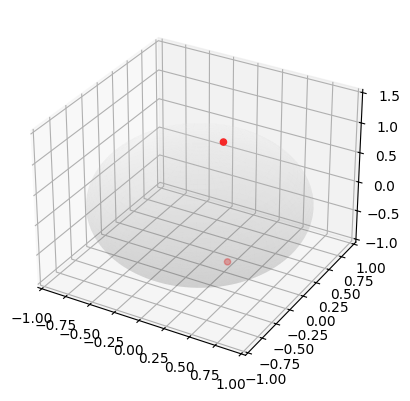

In [8]:
def generate_sphere_data(num_points: int = 1000):
    time_0_samples = np.abs(
        np.random.normal(loc=0, scale=0.5 / (2 * np.pi), size=num_points)
    )
    time_1_samples = 1 - np.abs(
        np.random.normal(loc=0, scale=0.5 / (2 * np.pi), size=num_points)
    )

    x0_samples, x1_samples = time_0_samples.flatten(), time_1_samples.flatten()

    phi_0 = np.pi * time_0_samples
    phi_1 = np.pi * time_1_samples

    theta_0 = 2 * np.pi * np.random.rand(num_points)
    theta_1 = 2 * np.pi * np.random.rand(num_points)

    x_0 = np.sin(phi_0) * np.cos(theta_0)
    y_0 = np.sin(phi_0) * np.sin(theta_0)
    z_0 = np.cos(phi_0)
    x_1 = np.sin(phi_1) * np.cos(theta_1)
    y_1 = np.sin(phi_1) * np.sin(theta_1)
    z_1 = np.cos(phi_1)

    # Combining points and creating labels
    points_0 = np.column_stack((x_0, y_0, z_0))
    points_1 = np.column_stack((x_1, y_1, z_1))

    points = np.concatenate([points_0, points_1])
    points_0, points_1 = torch.from_numpy(points_0), torch.from_numpy(points_1)
    return points, points_0, points_1

points, points_0, points_1 = generate_sphere_data(num_points=1)
visualize_hypersphere(points=points)

Let's plot the trajectory of the geodesic!

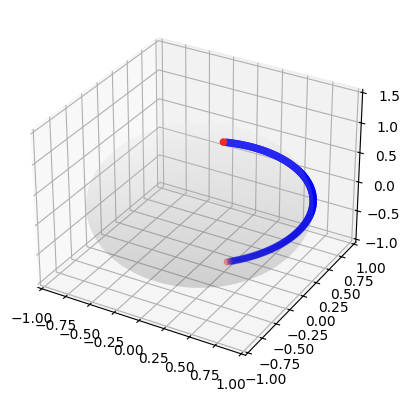

In [9]:
timesteps = torch.linspace(0.01, 0.99, 200)
traj = []
for t in timesteps:
  x_t = geodesic_interpolant(points_0, points_1, t)
  traj.append(x_t.detach().numpy())
traj = np.array(traj).squeeze()

# Visualizing the trajectory
visualize_hypersphere(points=points, traj=traj)

# Hyperbolic Geometry

Much of the code for this part of the tutorial is taken from these papers:

[1] Bose et. al 2020 https://github.com/joeybose/HyperbolicNF

[2] Skopek et. al 2020 https://github.com/oskopek/mvae

# Lorentz Model of Hyperbolic Geometry
Historically, hyperbolic space arose as an example of a geometry that is internally consistent but breaks Euclid's parallel postulate. An $n$-dimensional hyperbolic space, $\mathbb{H}^n_K$, is the unique, complete, simply-connected $n$-dimensional Riemannian manifold of constant negative curvature, $K$. In this tutorial we will focus on the Lorentz model of hyperboloc geometry due to it's useful numerical stability properties. The Lorentz model embeds hyperbolic space $\mathbb{H}^n_K$ within the $n+1$-dimensional Minkowski space, defined as the manifold $\mathbb{R}^{n+1}$ equipped with the following inner product:
\begin{equation}
    \langle x, y \rangle_{L} := -x_0y_0 + x_1y_1 + \dots + x_ny_n,
\end{equation}


In [10]:
def lorentz_product(x: Tensor, y: Tensor, keepdim: bool = False, dim: int = -1) -> Tensor:
    try:
        m = x * y
    except:
        m = torch.mm(x,y)
    if keepdim:
        ret = torch.sum(m, dim=dim, keepdim=True) - 2 * m[..., 0:1]
    else:
        ret = torch.sum(m, dim=dim, keepdim=False) - 2 * m[..., 0]
    return ret

def lorentz_norm(x: Tensor, **kwargs: Any) -> Tensor:
    product = lorentz_product(x, x, **kwargs)
    ret = sqrt(product)
    return ret

This resembles very much like the Euclidean inner product except that the first dimension plays a special role. One can define the $n$-Hyperbolic space with constant negative curvature $K$ with origin $\textbf{o} = (1/K, 0, \dots, 0)$, is a Riemannian manifold $(\mathbb{H}^{n}_K,g_{\textbf{x}})$ where
\begin{equation*}
    \mathbb{H}^{n}_K := \{x \in \mathbb{R}^{n+1}:  \langle x, x \rangle_{L} = 1/K, \ x_0 > 0, \ K<0 \}.
\end{equation*}
It is often convenient to use the generalized radius $R = 1/\sqrt{-K}$ in place of the curvature which we will be our convention for the remainder of this notebook.

We can now also define a few helper function that help with numerical stability. The first one is simply a clamped (defined later) version of a vanilla squareroot. The next function is the famous $\text{logsumexp}$ but adapted to the Hyperbolic setting where we must add additional clamping. The final helper function is quite a useful trick which allows us to take a point and interpret it as a point in the tangent space at the origin of $\mathbb{H}^n_K$ by prepending a $0$. We will later see this is a key step in defining the Wrapped Normal distribution for Hyperbolic spaces;

In [11]:
small_eps = 1e-7
max_clamp_norm = 40
max_norm = 85
ln_2: torch.Tensor = math.log(2)

# We will use this clamping technique to ensure numerical stability of the Exp and Log maps
class LeakyClamp(torch.autograd.Function):
    @staticmethod
    def forward(ctx: Any, x: torch.Tensor,
                min: float, max: float) -> torch.Tensor:
        ctx.save_for_backward(x.ge(min) * x.le(max))
        return torch.clamp(x, min=min, max=max)

    @staticmethod
    def backward(ctx: Any,
                 grad_output: torch.Tensor) -> Tuple[torch.Tensor, None, None]:
        mask, = ctx.saved_tensors
        mask = mask.type_as(grad_output)
        return grad_output * mask + grad_output * (1 - mask) * small_eps, None, None

def clamp(x: torch.Tensor, min: float = float("-inf"),
          max: float = float("+inf")) -> torch.Tensor:
    return LeakyClamp.apply(x, min, max)

def sqrt(x: torch.Tensor) -> torch.Tensor:
    x = clamp(x, min=1e-9)  # Smaller epsilon due to precision around x=0.
    return torch.sqrt(x)

def logsumexp_signs(value: torch.Tensor, dim: int = 0, keepdim: bool = False,
                    signs: Optional[torch.Tensor] = None) -> torch.Tensor:
    if signs is None:
        signs = torch.ones_like(value)
    m, _ = torch.max(value, dim=dim, keepdim=True)
    value0 = value - m
    if keepdim is False:
        m = m.squeeze(dim)
    return m + torch.log(clamp(torch.sum(signs * torch.exp(value0),
                                               dim=dim,
                                               keepdim=keepdim), min=small_eps))

def expand_proj_dims(x: torch.Tensor) -> torch.Tensor:
    zeros = torch.zeros(x.shape[:-1] + torch.Size([1])).to(x.device).to(x.dtype)
    return torch.cat((zeros, x), dim=-1)

# The Exponential Map
The exponential map takes a vector, $v$, in the tangent space of a point $x \in \mathbb{H}^{n}_K$ to a point on the manifold---i.e., $y = \text{exp}^K_\textbf{x}(v): T_{x} \mathbb{H}^{n}_K \to \mathbb{H}^{n}_K$ by moving a unit length along the geodesic, $\gamma$. The closed form expression for the exponential map is then given by
\begin{equation}
    \text{exp}^K_{x} (v) = \cosh \Big(\frac{||v||_{L}}{R} \Big)x +  \sinh \Big(\frac{||v||_{L}}{R} \Big)\frac{Rv}{||{v}||_{L}},
\end{equation}
In code, we must be doubly careful about numerical instability when using hyperbolic functions. This is obvious if we look at the explicit formulas for hyperbolic trigonometric functions ---i.e. $\sinh = \frac{e^x - e^{-x}}{2}$. Thus the value of $x$ has to be clamped otherwise we risk numerical overflow. For example, we can define a numerically stable version of the $\text{exp}$ and $\log$ maps as follows:

In [12]:
def cosh(x: torch.Tensor) -> torch.Tensor:
    x = clamp(x, min=-max_norm, max=max_norm)
    return torch.cosh(x)

def sinh(x: torch.Tensor) -> torch.Tensor:
    x = clamp(x, min=-max_norm, max=max_norm)
    return torch.sinh(x)

def logsinh(x: torch.Tensor) -> torch.Tensor:
    x_exp = x.unsqueeze(dim=-1)
    signs = torch.cat((torch.ones_like(x_exp), -torch.ones_like(x_exp)), dim=-1)
    value = torch.cat((torch.zeros_like(x_exp), -2. * x_exp), dim=-1)
    return x + logsumexp_signs(value, dim=-1, signs=signs) - ln_2

def exp_map(x: Tensor, at_point: Tensor, radius: Tensor) -> Tensor:
    x_norm = lorentz_norm(x, keepdim=True) / radius
    x_normed = x / x_norm
    ret = cosh(x_norm) * at_point + sinh(x_norm) * x_normed
    assert torch.isfinite(ret).all()
    return ret

# Exp map for the origin has a special form which doesn't need the Lorentz norm
def exp_map_mu0(x: Tensor, radius: Tensor) -> Tensor:
    assert x[..., 0].allclose(torch.zeros_like(x[..., 0]))
    x = x[..., 1:]
    x_norm = torch.norm(x, p=2, keepdim=True, dim=-1) / radius
    x_normed = F.normalize(x, p=2, dim=-1) * radius
    ret = torch.cat((cosh(x_norm) * radius, sinh(x_norm) * x_normed), dim=-1)
    assert torch.isfinite(ret).all()
    return ret

As the inverse of the exponential map, the logarithmic map takes a point, $y$, on the manifold back to the tangent space of another point $x$ also on the manifold. In the Lorentz model this is defined as
\begin{equation}
    \log^K_{\textbf{x}}{\textbf{y}} = \frac{\text{arccosh}(\alpha)}{\sqrt{\alpha^2 - 1}}(y - \alpha x),
\end{equation}
where $\alpha = K\langle x, y \rangle_{L}$. We must again be careful of numerical stability when implementing inverse hyperbolic trignometric functions but this is easily handled as follows:

In [13]:
class Acosh(torch.autograd.Function):
    """
    Numerically stable arccosh that never returns NaNs.
    Returns acosh(x) = arccosh(x) = log(x + sqrt(max(x^2 - 1, eps))).
    """
    @staticmethod
    def forward(ctx: Any, x: torch.Tensor) -> torch.Tensor:
        x = clamp(x, min=1 + small_eps)
        z = sqrt(x * x - 1.)
        ctx.save_for_backward(z)
        return torch.log(x + z)

    @staticmethod
    def backward(ctx: Any, grad_output: torch.Tensor) -> torch.Tensor:
        z, = ctx.saved_tensors
        # z_ = clamp(z, min=eps)
        z_ = z
        return grad_output / z_

def acosh(x: torch.Tensor) -> torch.Tensor:
    """
    Numerically stable arccosh that never returns NaNs.
    :param x: The input tensor.
    :return: log(x + sqrt(max(x^2 - 1, eps))
    """
    return Acosh.apply(x)

def inverse_exp_map(x: Tensor, at_point: Tensor, radius: Tensor) -> Tensor:
    alpha = -lorentz_product(at_point, x, keepdim=True) / (radius**2)
    coef = acosh(alpha) / sqrt(alpha**2 - 1)
    ret = coef * (x - alpha * at_point)
    return ret

# Parallel Transport
The parallel transport for two points $x,y \in \mathbb{H}^{n}_K$ is a map that carries the vectors in $v \in T_{x}\mathbb{H}^{n}_K$ to corresponding vectors at $v' \in T_{y}\mathbb{H}^{n}_K$ along the geodesic. Parallel transport is a map that preserves the metric, ie, $\langle \text{PT}^K_{x \to y}(v), \text{PT}^K_{x \to y}(v') \rangle_{L} = \langle v, v' \rangle_{L}$ and in the Lorentz model is given by
\begin{align}
    \text{PT}^K_{x \to y}(v) & = v - \frac{ \langle \log^K_{x}(y), v \rangle_{L}}{d(x,y)_{L}} (\log^K_{x}(y)+ \log^K_{y}(x)) \\
    & = v + \frac{ \langle y, v \rangle_{L}}{R^2 - \langle x, y \rangle_{L}} (x+ y),
\end{align}
where $\alpha$ is as defined in the $\log$ map. Another useful property is that the inverse parallel transport simply carries the vectors back along the geodesic and is simply defined as $(\text{PT}^{K}_{x \to y}(v))^{-1} = \text{PT}^K_{y \to x}(v)$. Remarkably, parallel transport requires simple operations like the Lorentz product which makes implementation a breeze. Let's see how to implement both parallel and inverse parallel transport when one of the tangent spaces is the origin.

In [14]:
def parallel_transport_mu0(x: Tensor, dst: Tensor, radius: Tensor) -> Tensor:
    # PT_{mu0 -> dst}(x) = x + <dst, x>_L / (R^2 - <mu0, dst>_L) * (mu0+dst)
    denom = radius * (radius + dst[..., 0:1])
    lp = lorentz_product(dst, x, keepdim=True)
    coef = lp / denom
    right = torch.cat((dst[..., 0:1] + radius, dst[..., 1:]), dim=-1)  # mu0 + dst
    return x + coef * right

def inverse_parallel_transport_mu0(x: Tensor, src: Tensor, radius: Tensor) -> Tensor:
    # PT_{src -> mu0}(x) = x + <mu0, x>_L / (R^2 - <src, mu0>_L) * (src+mu0)
    denom = (radius + src[..., 0:1])
    lp = -x[..., 0:1]
    coef = lp / denom
    right = torch.cat((src[..., 0:1] + radius, src[..., 1:]), dim=-1)  # mu0 + src
    return x + coef * right

# Defining a Wrapped Normal Distribution in Hyperbolic Space
We will now see how to define one type of Normal Distribution in Hyperbolic Space. Note this is not the only way to define probability distributions but for the purposes of this tutorial it will help illustrate a few of the basic concepts when working with. The Wrapped Normal distribution can constructed in 3 steps


1.    Sample from $N(0,I)$ and then transform it to a point $v \in T_{o}\mathbb{H}_K^n$ by concatenating $0$ as the zeroth coordinate;
2.   Parallel transport the sample $v$ from the tangent space at $o$ to the tangent space of another point $\boldsymbol{\mu} $ on the manifold to obtain $u$;
3. Map $u$ from the tangent space to the manifold using the exponential map at $\boldsymbol{\mu}$.

Sampling from such a distribution is straightforward and the probability density can be obtained via the change of variable formula,
\begin{align}
    \log p(z) = \log p(v) - (n-1) \log \left(\frac{\sinh{ ( \Vert u \Vert_{L} ) }}{ \Vert u \Vert_{L} } \right),
\end{align}
where $p(\textbf{z})$ is the wrapped normal distribution and $p(v)$ is the normal distribution in the tangent space of $\textbf{o}$. Note that the change of variable formulas are needed because we are utilizing $\text{exp}$ and $\log$ maps at different points ---due to parallel transport--- thus they don't cancel each other out and we must correct for the change in volume.

In [15]:
class HyperboloidWrappedNormal(torch.distributions.Distribution):
    support = torch.distributions.constraints.real
    has_rsample = True

    def __init__(self, radius:Tensor, loc: Tensor,
                 scale: Tensor, *args: Any, **kwargs: Any) -> None:
        super().__init__(*args, **kwargs)
        self.dim = loc.shape[-1]
        self.radius = radius
        tangent_dim = self.dim - 1
        if scale.shape[-1] > 1 and scale.shape[-1] != tangent_dim:
            raise ValueError("Invalid scale dimension: neither isotropic nor elliptical.")

        if scale.shape[-1] == 1:  # repeat along last dim for (loc.shape[-1] - 1) times.
            s = [1] * len(scale.shape)
            s[-1] = tangent_dim
            scale = scale.repeat(s)  # Expand scalar scale to vector.

        # Loc has to be one dim bigger than scale or equal (in projected spaces).
        assert loc.shape[:-1] == scale.shape[:-1]
        assert tangent_dim == scale.shape[-1]

        self.loc = loc
        self.scale = scale
        self.device = self.loc.device
        smaller_shape = self.loc.shape[:-1] + torch.Size([tangent_dim])
        self.normal = torch.distributions.Normal(torch.zeros(smaller_shape,
                                                             device=self.device),
                                                 scale)

    @property
    def mean(self) -> Tensor:
        return self.loc

    @property
    def stddev(self) -> Tensor:
        return self.scale

    def logdet(self, radius: Tensor, mu: Tensor, std: Tensor,
               z: Tensor, data: Tuple[Tensor, ...]) -> Tensor:
        u = data[0]
        r = lorentz_norm(u, dim=-1) / radius
        n = u.shape[-1] - 1
        logdet_partial = (n - 1) * (torch.log(radius) + logsinh(r) - torch.log(r))
        assert torch.isfinite(logdet_partial).all()
        return logdet_partial

    def sample_projection_mu0(self, x: Tensor, at_point: Tensor,
                              radius: Tensor) -> Tuple[Tensor, Tuple[Tensor, Tensor]]:
        x_expanded = expand_proj_dims(x)
        pt = parallel_transport_mu0(x_expanded, dst=at_point, radius=radius)
        pt = clamp(pt, min=-max_clamp_norm, max=max_clamp_norm)
        x_proj = exp_map(pt, at_point=at_point, radius=radius)
        return x_proj, (pt, x)

    def rsample_with_parts(self,
                           shape: torch.Size = torch.Size()) -> Tuple[Tensor, Tuple[Tensor, ...]]:
        # v ~ N(0, \Sigma)
        v_tilde = self.normal.rsample(shape)
        assert torch.isfinite(v_tilde).all()
        # u = PT_{mu_0 -> mu}([0, v_tilde])
        # z = exp_{mu}(u)
        z, helper_data = self.sample_projection_mu0(v_tilde,
                                                    at_point=self.loc,
                                                    radius=self.radius)
        assert torch.isfinite(z).all()
        return z, helper_data

    def rsample(self, sample_shape: torch.Size = torch.Size()) -> Tensor:
        z, _ = self.rsample_with_parts(sample_shape)
        return z

    def inverse_sample_projection_mu0(self, x: Tensor, at_point: Tensor,
                                      radius: Tensor) -> Tuple[Tensor, Tensor]:
        unmapped = inverse_exp_map(x, at_point=at_point, radius=radius)
        unmapped = clamp(unmapped, min=-max_clamp_norm, max=max_clamp_norm)
        unpt = inverse_parallel_transport_mu0(unmapped,
                                              src=at_point,
                                              radius=radius)
        unpt = clamp(unpt, min=-max_clamp_norm, max=max_clamp_norm)
        return unmapped, unpt[..., 1:]

    def log_prob_from_parts(self, z: Tensor,
                            data: Optional[Tuple[Tensor, ...]]) -> Tensor:
        if data is None:
            raise ValueError("Additional data cannot be empty for WrappedNormal.")

        # log(z) = log p(v) - log det [(\partial / \partial v) proj_{\mu}(v)]
        v = data[1]
        assert torch.isfinite(v).all()
        n_logprob = self.normal.log_prob(v).sum(dim=-1)
        logdet = self.logdet(self.radius, self.loc,
                             self.scale, z, (*data, n_logprob))
        assert n_logprob.shape == logdet.shape
        log_prob = n_logprob - logdet
        assert torch.isfinite(log_prob).all()
        return log_prob

    def log_prob(self, z: Tensor) -> Tensor:
        """Should only be used for p_z, prefer log_prob_from_parts."""
        assert torch.isfinite(z).all()
        data = self.inverse_sample_projection_mu0(z, at_point=self.loc,
                                                  radius=self.radius)
        return self.log_prob_from_parts(z, data)

    def log_prob_straight(self, z: Tensor) -> Tensor:
        """Should only be used for p_z, prefer log_prob_from_parts."""
        assert torch.isfinite(z).all()
        data = self.sample_projection_mu0(z, at_point=self.loc,
                                          radius=self.radius)
        return self.log_prob_from_parts(z, data)

# Visualizing Wrapped Normals
The Lorentz Model of Hyperbolic Geometry is fantastic for numerical computation but for the purposes of visualization the 2-D Poincare model is better. As these models are isometries we can easily convert between the two based on need.

In [16]:
# Converts Lorentz Model of Hyperbolic Geometry to Poincare Model
def lorentz_to_poincare(x: Tensor, radius: Tensor) -> Tensor:
    return radius * x[..., 1:] / (radius + x[..., 0:1])

# Helper function to do the plotting
def plot_density(xy_poincare, probs, radius, mu=None):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    x = xy_poincare[:, 0].view(-1, 100).detach().cpu().numpy()
    y = xy_poincare[:, 1].view(-1, 100).detach().cpu().numpy()
    z = probs.view(-1, 100).detach().cpu().numpy()
    range_lim = 2
    # Define points within circle
    if mu is not None:
        mu = mu.cpu().numpy()
        plt.plot(mu[:, 0], mu[:, 1], 'b+')
    ax.contourf(x, y, z, 100, antialiased=False, cmap='magma')
    ax.axis('off')

    # Makes the circle look like a circle
    ax.axis('equal')
    axis_lim = 1.0
    ax.set_xlim(-axis_lim, axis_lim)
    ax.set_ylim(-axis_lim, axis_lim)

# Wrapped Normal Distribution
To plot the wrapped normal distribution we can do the follow. First we can define the wrapped normal using the class defined above. Having defined the distribution we can readily compute the probability of a sampled point which we will leverage to define the density over the entire Poincare disk. To do so we can simply create a mesh grid in $\mathbb{R}^2$ and interpret the points on $T_o\mathbb{H}_K^3$ by prepending by $0$. Finally, we can leverage the exponential map to push these points to the $\mathbb{H}_K^3$. Having a series of points on the manifold we can then easily calcualte the probability of each point and use this for visualization on the Poincare disk. These steps are demonstrated below in the following code snippet:

/usr/local/lib/python3.10/dist-packages/torch/distributions/distribution.py:56: UserWarning: <class '__main__.HyperboloidWrappedNormal'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(


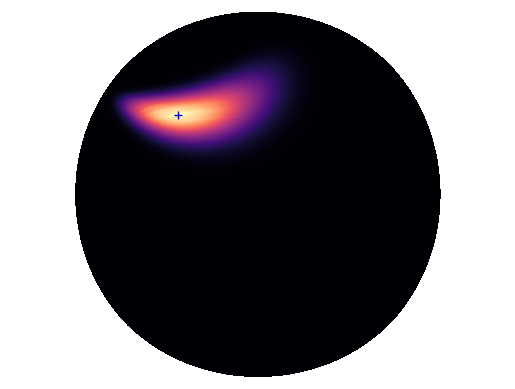

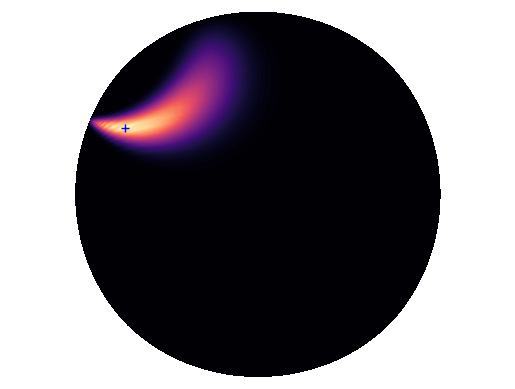

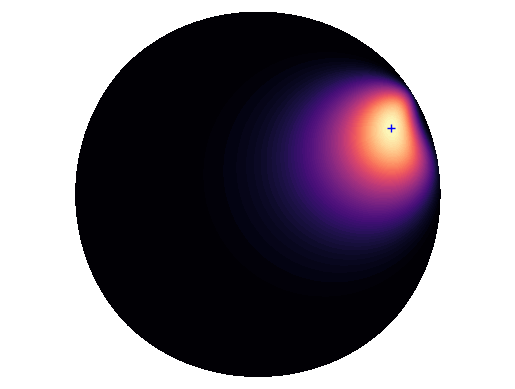

In [17]:
# Constants
dev = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
mean_1 = torch.Tensor([-1., 1.]).unsqueeze(0).to(dev)
std_1 = torch.Tensor([[1.0], [0.25]]).T.to(dev)
mean_2 = torch.Tensor([-2., 1.]).unsqueeze(0).to(dev)
std_2 = torch.Tensor([[3.0], [0.25]]).T.to(dev)
mean_3 = torch.Tensor([2., 1.]).unsqueeze(0).to(dev)
std_3 = torch.Tensor([[1.0], [2.5]]).T.to(dev)
radius = torch.Tensor([1.0]).to(dev)
axis_lim = 1.0
K = 500 # Number of Samples

def gauss(mu, std):
    mu = clamp(mu, min=-max_clamp_norm, max=max_clamp_norm)
    mu_h = exp_map_mu0(expand_proj_dims(mu), radius)

    p_z = HyperboloidWrappedNormal(radius, mu_h, std)

    # Map x, y coordinates on tangent space at origin to manifold (Lorentz model).
    x = np.arange(-5, 5, 0.1)
    y = np.arange(-5, 5, 0.1)
    x, y = np.meshgrid(x, y)
    x = torch.Tensor(x).view(-1, 1)
    y = torch.Tensor(y).view(-1, 1)
    twodim = torch.cat([x, y], dim=1)
    threedim = expand_proj_dims(twodim)
    clamped_threedim = clamp(threedim, min=-max_clamp_norm,
            max=max_clamp_norm).to(dev)
    on_mani = exp_map_mu0(clamped_threedim, radius)

    # Calculate densities of x, y coords on Lorentz model.
    probs = p_z.log_prob(on_mani)
    probs = torch.exp(probs)

    # Calculate the poincare coordinates
    xy_poincare = lorentz_to_poincare(on_mani.squeeze(), radius)
    mu_p = lorentz_to_poincare(mu_h, radius)

    plot_density(xy_poincare, probs, radius, mu=mu_p)

gauss(mean_1, std_1)
gauss(mean_2, std_2)
gauss(mean_3, std_3)

# Toroidal Geometry

We'll consider a Torus in 3D next.
A torus can be parametrized with two angles $\theta, \phi \in [0, 2 \pi]$ which allows for its definition about the minor radius $r$, and major radius $R$.

\begin{equation}
\mathbb{T}^2 =
  \begin{cases}
    x(\theta, \phi) = (R + r\cos \theta)\cos \phi \\
    y(\theta, \phi) = (R + r\cos \theta)\sin \phi \\
    z(\theta, \phi) = r \sin \theta
  \end{cases}
\end{equation}

The torus is also diffeomorphic to $\mathbb{T}^2 = \mathbb{S}^1 \times \mathbb{S}^1$ so that offers another possible representation. We can even go 1 step more---for no particularly good reason---and expoit the fact that $S^1 = \mathrm{SO}(2)$, i.e. the homogenous space for rotations in 2D is the unit circle.

Let's generate some toy data!

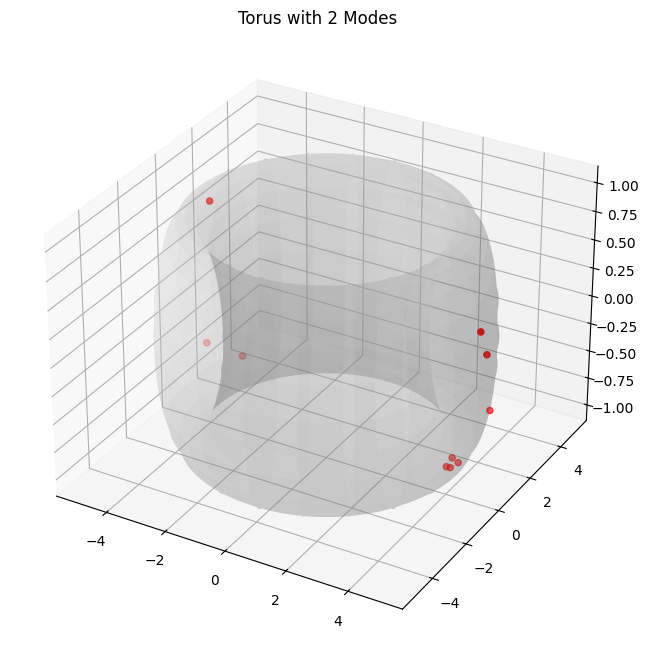

In [37]:
def generate_torus_data_with_modes(num_samples=10, R=5, r=2, num_modes=3):
    """
    Generate synthetic data points on a torus with 3 modes placed equidistantly.

    Parameters:
    - num_samples: Number of data points to generate.
    - R: Major radius of the torus.
    - r: Minor radius of the torus.
    - num_modes: Number of modes in the distribution (default is 3).

    Returns:
    - A tensor of shape (num_samples, 2, 2) containing the cos and sin values for angles theta and phi.
    """
    # Generate uniform theta across all points
    theta = torch.rand(num_samples) * 2 * torch.pi

    # Generate phi with 2 modes
    mode_width = 2 * torch.pi / num_modes / 4  # Width of each mode, divided by 4 for some overlap
    mode_centers = torch.linspace(0, 2 * torch.pi, num_modes + 1)[:-1]  # Avoid the endpoint to get equidistant centers
    phi_modes = torch.rand(num_samples) * mode_width - mode_width / 2  # Random offset within each mode

    # Assign each sample to a mode, and adjust phi accordingly
    mode_assignments = torch.randint(0, num_modes, (num_samples,))
    phi = (mode_centers[mode_assignments] + phi_modes) % (2 * torch.pi)

    # Convert angles to points on the unit circle (cos and sin values)
    theta_points = torch.stack([torch.cos(theta), torch.sin(theta)], dim=1)
    phi_points = torch.stack([torch.cos(phi), torch.sin(phi)], dim=1)

    # Combine to get the final shape N x 2 x 2
    data = torch.stack([theta_points, phi_points], dim=1)
    data_angles = torch.stack([theta, phi], dim=1)
    return data, data_angles

def visualize_torus_data(data: Tensor, R=4, r=1, traj=None):
    """
    Visualize the torus with 3 modes placed equidistantly on the surface.

    Parameters:
    - data: A tensor of shape (N, 2, 2) containing the cos and sin values for angles theta and phi.
    - R: Major radius of the torus.
    - r: Minor radius of the torus.
    """
    # Generate the torus surface
    theta, phi = np.mgrid[0:2*np.pi:100j, 0:2*np.pi:100j]
    x = (R + r * np.cos(theta)) * np.cos(phi)
    y = (R + r * np.cos(theta)) * np.sin(phi)
    z = r * np.sin(theta)

    # Extract the sampled points
    cos_theta, sin_theta = data[:, 0, 0].numpy(), data[:, 0, 1].numpy()
    cos_phi, sin_phi = data[:, 1, 0].numpy(), data[:, 1, 1].numpy()
    x_samples = (R + r * cos_theta) * cos_phi
    y_samples = (R + r * cos_theta) * sin_phi
    z_samples = r * sin_theta

    # Plotting
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Plot the torus surface
    ax.plot_surface(x, y, z, color='lightgrey', alpha=0.2, rstride=5, cstride=5, edgecolor='none')

    # Overlay the sampled points with different colors for clarity
    ax.scatter(x_samples, y_samples, z_samples, color='red', s=20)  # Sampled points

    if traj is not None:
      traj_cos_theta, traj_sin_theta = traj[:, 0, 0], traj[:, 0, 1]
      traj_cos_phi, traj_sin_phi = traj[:, 1, 0], traj[:, 1, 1]
      traj_x_samples = (R + r * traj_cos_theta) * traj_cos_phi
      traj_y_samples = (R + r * traj_cos_theta) * traj_sin_phi
      traj_z_samples = r * traj_sin_theta
      ax.scatter(traj_x_samples, traj_y_samples,
                 traj_z_samples, color="blue", marker='o')

    ax.set_title('Torus with 2 Modes')
    plt.show()


num_samples = 10
torus_data_modes, torus_data_angles = generate_torus_data_with_modes(num_samples, num_modes=2)
visualize_torus_data(torus_data_modes)

Let's now code up a simple Torus class using the diffeomorphism. We will use the geoopt package to handle the product manifold.

In [19]:
import geoopt
from geoopt.manifolds import ProductManifold

sphere = geoopt.Sphere()
torus = ProductManifold((sphere, 2), (sphere, 2))

Let's make a geodesic Interpolant again!

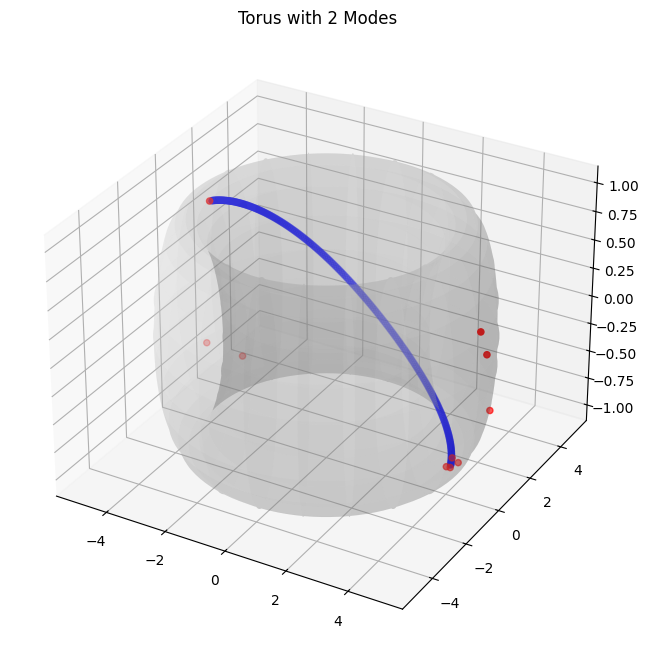

In [39]:
import pdb

def torus_geodesic_interpolant(x_0: Tensor, x_1: Tensor, t: Tensor):
    x_t = torus.expmap(x_0, t * torus.logmap(x_0, x_1))
    return x_t

points_0 = torus_data_modes[0].reshape(-1, 4)
points_1 = torus_data_modes[1].reshape(-1, 4)
timesteps = torch.linspace(0.01, 0.99, 200)
traj = []
for t in timesteps:
  x_t = torus_geodesic_interpolant(points_0, points_1, t)
  x_t = x_t.reshape(-1, 2, 2)
  traj.append(x_t.detach().numpy())
traj = np.array(traj).squeeze()
visualize_torus_data(torus_data_modes, traj=traj)